In [1]:
# Google Play Store Apps — Data Audit & Processing (clean + scale decision)
import os, glob, json, random, re
import numpy as np
import pandas as pd

SEED = 42
random.seed(SEED); np.random.seed(SEED)

pd.set_option("display.max_columns", 120)


In [2]:
# Locate the CSV from lava18/google-play-store-apps
candidates = glob.glob("/kaggle/input/**/googleplaystore.csv", recursive=True)
if not candidates:
    raise FileNotFoundError("Could not find googleplaystore.csv in /kaggle/input. Add the dataset from the right sidebar.")
path = candidates[0]

df_raw = pd.read_csv(path)
df = df_raw.copy()
print("File:", path)
print("Shape:", df.shape)
display(df.head(3))
display(df.dtypes)

# Quick nulls / uniques for important columns
key_cols = ["App","Category","Rating","Reviews","Size","Installs","Type","Price","Content Rating","Genres","Last Updated","Current Ver","Android Ver"]
present = [c for c in key_cols if c in df.columns]
print("\nMissing values (top 15):")
display(df[present].isna().sum().sort_values(ascending=False).head(15))

print("\nUnique counts (selected):")
display(df[present].nunique().sort_values(ascending=False))


File: /kaggle/input/google-play-store-apps/googleplaystore.csv
Shape: (10841, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


Missing values (top 15):


Rating            1474
Current Ver          8
Android Ver          3
Content Rating       1
Type                 1
Size                 0
Reviews              0
Category             0
App                  0
Price                0
Installs             0
Last Updated         0
Genres               0
dtype: int64


Unique counts (selected):


App               9660
Reviews           6002
Current Ver       2832
Last Updated      1378
Size               462
Genres             120
Price               93
Rating              40
Category            34
Android Ver         33
Installs            22
Content Rating       6
Type                 3
dtype: int64

In [3]:
df = df.copy()

# 3.1 Clean Installs: remove '+' and ',' → int
def parse_installs(s):
    if pd.isna(s): return np.nan
    s = str(s).strip().replace('+','').replace(',','')
    return pd.to_numeric(s, errors='coerce')

df["Installs_num"] = df["Installs"].map(parse_installs)

# 3.2 Clean Price: '$0.99' → 0.99
def parse_price(s):
    if pd.isna(s): return np.nan
    s = str(s).strip().replace('$','')
    return pd.to_numeric(s, errors='coerce')

df["Price_num"] = df["Price"].map(parse_price)

# 3.3 Clean Size: '14M' → 14.0 MB; '512k' → 0.512 MB; 'Varies with device' → NaN
def parse_size(s):
    if pd.isna(s): return np.nan
    s = str(s).strip()
    if "Varies with device" in s: return np.nan
    m = re.match(r'^([0-9]*\.?[0-9]+)\s*([kKmM])?$', s)
    if not m: return np.nan
    val = float(m.group(1))
    unit = m.group(2)
    if not unit: return val  # assume already MB (rare)
    if unit.lower() == 'k': return val / 1024.0
    if unit.lower() == 'm': return val
    return np.nan

df["Size_MB"] = df["Size"].map(parse_size)

# 3.4 Reviews → numeric
df["Reviews_num"] = pd.to_numeric(df["Reviews"], errors="coerce")

# 3.5 Rating → numeric (0–5)
df["Rating_num"] = pd.to_numeric(df["Rating"], errors="coerce")

# 3.6 Primary genre (before ';')
if "Genres" in df.columns:
    df["Genre_primary"] = df["Genres"].astype(str).str.split(";").str[0].str.strip().str.lower()
else:
    df["Genre_primary"] = "unknown"

# 3.7 Last Updated → days since last update (relative to max date seen)
if "Last Updated" in df.columns:
    dt = pd.to_datetime(df["Last Updated"], errors="coerce")
    max_dt = pd.Timestamp(dt.max())
    df["days_since_update"] = (max_dt - dt).dt.days.astype("float32")
else:
    df["days_since_update"] = np.nan

# 3.8 Type → Free=0, Paid=1
type_map = {"Free":0, "Paid":1}
df["Type_is_paid"] = df["Type"].map(type_map)

# 3.9 Content Rating (categorical small)
df["ContentRating_cat"] = df["Content Rating"].astype(str).str.strip().str.lower()

# 3.10 Category as lower
df["Category_cat"] = df["Category"].astype(str).str.strip().str.lower()

# 3.11 Drop exact duplicate rows; then deduplicate keeping the most recently updated per App+Category
df = df.drop_duplicates()
if {"App","Category"}.issubset(df.columns):
    # Keep row with smallest days_since_update (most recent)
    df.sort_values(by=["App","Category","days_since_update"], ascending=[True,True,True], inplace=True)
    df = df.drop_duplicates(subset=["App","Category"], keep="first")

# 3.12 Keep rows with valid target & critical numerics
keep = (
    df["Installs_num"].notna() &
    (df["Installs_num"] >= 0) &
    df["Reviews_num"].notna()
)
df = df[keep].copy()

print("After cleaning:", df.shape)
df[["App","Category","Installs","Installs_num","Price","Price_num","Size","Size_MB","Reviews","Reviews_num","Rating_num"]].head(5)


After cleaning: (9744, 23)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,App,Category,Installs,Installs_num,Price,Price_num,Size,Size_MB,Reviews,Reviews_num,Rating_num
8884,"""i DT"" Fútbol. Todos Somos Técnicos.",SPORTS,500+,500.0,0,0.0,3.6M,3.600000,27,27.0,NaN
8532,+Download 4 Instagram Twitter,SOCIAL,"1,000,000+",1000000.0,0,0.0,22M,22.000000,40467,40467.0,4.5
324,- Free Comics - Comic Apps,COMICS,"10,000+",10000.0,0,0.0,9.1M,9.100000,115,115.0,3.5
4541,.R,TOOLS,"10,000+",10000.0,0,0.0,203k,0.198242,259,259.0,4.5
4636,/u/app,COMMUNICATION,"10,000+",10000.0,0,0.0,53M,53.000000,573,573.0,4.7


In [4]:
num_cols_raw = ["Installs_num","Price_num","Size_MB","Reviews_num","Rating_num","days_since_update"]
num_cols = [c for c in num_cols_raw if c in df.columns]

prof = pd.DataFrame({
    "min": df[num_cols].min(),
    "p50": df[num_cols].median(),
    "p90": df[num_cols].quantile(0.90),
    "p99": df[num_cols].quantile(0.99),
    "max": df[num_cols].max(),
    "mean": df[num_cols].mean(),
    "std": df[num_cols].std(ddof=0),
    "skew": df[num_cols].skew(),
})
prof["range"] = prof["max"] - prof["min"]
prof.sort_values("range", ascending=False)


,min,p50,p90,p99,max,mean,std,skew,range
Installs_num,0.000000,100000.0,10000000.0,1.000000e+08,1.000000e+09,8.208913e+06,5.527773e+07,14.504113,1.000000e+09
Reviews_num,0.000000,1017.0,236999.4,4.930211e+06,7.815831e+07,2.381124e+05,1.934311e+06,24.065227,7.815831e+07
days_since_update,0.000000,93.0,835.7,1.810280e+03,3.001000e+03,2.792538e+02,4.054991e+02,2.233202,3.001000e+03
Price_num,0.000000,0.0,0.0,8.990000e+00,4.000000e+02,1.089401e+00,1.677759e+01,22.631052,4.000000e+02
Size_MB,0.008301,12.0,52.0,9.600000e+01,1.000000e+02,2.052651e+01,2.194342e+01,1.638897,9.999170e+01
Rating_num,1.000000,4.3,4.7,5.000000e+00,5.000000e+00,4.175012e+00,5.346745e-01,-1.753006,4.000000e+00


In [5]:
df_proc = df.copy()

# 5.1 Regression target: log1p(installs)
df_proc["log_installs"] = np.log1p(df_proc["Installs_num"])

# 5.2 Light caps on numeric inputs to reduce extreme leverage
cap_lo, cap_hi = 0.01, 0.995
for c in ["Price_num","Size_MB","Reviews_num","Rating_num","days_since_update"]:
    if c in df_proc.columns:
        lo = df_proc[c].quantile(cap_lo)
        hi = df_proc[c].quantile(cap_hi)
        df_proc[c] = df_proc[c].clip(lower=lo, upper=hi)

# 5.3 Choose features (mix of numeric + small categoricals)
num_feats = [c for c in ["Price_num","Size_MB","Reviews_num","Rating_num","days_since_update"] if c in df_proc.columns]
cat_feats = []
if "Category_cat" in df_proc.columns:       cat_feats.append("Category_cat")
if "ContentRating_cat" in df_proc.columns:  cat_feats.append("ContentRating_cat")
if "Genre_primary" in df_proc.columns:      cat_feats.append("Genre_primary")
if "Type_is_paid" in df_proc.columns:       num_feats.append("Type_is_paid")  # binary as numeric

feature_cols = num_feats + cat_feats
target_col = "log_installs"

print("Numeric features:", num_feats)
print("Categorical features:", cat_feats)
print("Target:", target_col)
print("Rows:", df_proc.shape[0])


Numeric features: ['Price_num', 'Size_MB', 'Reviews_num', 'Rating_num', 'days_since_update', 'Type_is_paid']
Categorical features: ['Category_cat', 'ContentRating_cat', 'Genre_primary']
Target: log_installs
Rows: 9744


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


In [6]:
# Limit high-cardinality categoricals by keeping top-N levels per field
def top_levels(s, topn=30, other_label="other"):
    s = s.fillna(other_label).astype(str)
    vc = s.value_counts()
    keep = set(vc.head(topn).index)
    return s.where(s.isin(keep), other_label)

df_enc = df_proc.copy()
for c in cat_feats:
    df_enc[c] = top_levels(df_enc[c], topn=30)

X_cats = pd.get_dummies(df_enc[cat_feats], drop_first=False, dtype=np.uint8) if cat_feats else pd.DataFrame(index=df_enc.index)
X_nums = df_enc[num_feats].astype(np.float32)
X = pd.concat([X_nums, X_cats], axis=1)
y = df_enc[target_col].astype(np.float32).values

print("Design matrix shape:", X.shape)
print("One-hot columns:", X_cats.shape[1] if len(cat_feats) else 0)

# Scale audit: numeric ranges before scaling
if not X_nums.empty:
    num_prof = pd.DataFrame({"min": X_nums.min(), "max": X_nums.max(), "std": X_nums.std(ddof=0), "skew": X_nums.skew()})
    num_prof["range"] = num_prof["max"] - num_prof["min"]
    display(num_prof.sort_values("range", ascending=False).head(10))
else:
    print("No numeric columns? (unexpected)")


Design matrix shape: (9744, 74)
One-hot columns: 68


,min,max,std,skew,range
Reviews_num,0.000000,8.139170e+06,828446.000000,7.410295,8.139170e+06
days_since_update,2.000000,1.994140e+03,397.438477,2.076645,1.992140e+03
Size_MB,0.196289,9.900000e+01,21.936543,1.637725,9.880371e+01
Price_num,0.000000,1.727500e+01,1.712036,7.264838,1.727500e+01
Rating_num,2.200000,5.000000e+00,0.512171,-1.383900,2.800000e+00
Type_is_paid,0.000000,1.000000e+00,0.267702,3.155606,1.000000e+00


In [7]:
from sklearn.model_selection import train_test_split

X_np = X.values.astype(np.float32)
cat_col_idx = list(range(len(num_feats), X.shape[1]))  # positions of one-hot columns
num_col_idx = list(range(0, len(num_feats)))           # positions of numeric columns

X_train, X_tmp, y_train, y_tmp = train_test_split(X_np, y, test_size=0.30, random_state=SEED)
X_val,   X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=SEED)

print("Splits:", X_train.shape, X_val.shape, X_test.shape)

# Save feature metadata for later modeling/export
ART = "/kaggle/working/artifacts"; os.makedirs(ART, exist_ok=True)
meta = {
    "feature_cols_order": X.columns.tolist(),
    "numeric_feature_count": len(num_feats),
    "categorical_feature_count": X.shape[1] - len(num_feats),
    "target": target_col
}
with open(os.path.join(ART, "features_meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("Saved metadata to", os.path.join(ART, "features_meta.json"))


Splits: (6820, 74) (1462, 74) (1462, 74)
Saved metadata to /kaggle/working/artifacts/features_meta.json


In [8]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer

def scale_numeric(scaler_name, X_train, X_val, X_test, num_idx):
    if scaler_name == "standard":
        sc = StandardScaler()
    elif scaler_name == "robust":
        sc = RobustScaler()
    elif scaler_name == "quantile":
        sc = QuantileTransformer(output_distribution="normal", random_state=SEED, n_quantiles=min(1000, X_train.shape[0]))
    else:
        raise ValueError(scaler_name)
    # clone arrays to not mutate originals
    Xt, Xv, Xe = [arr.copy() for arr in (X_train, X_val, X_test)]
    # fit/transform numeric slice only
    Xt_num = sc.fit_transform(Xt[:, num_idx])
    Xv_num = sc.transform(Xv[:, num_idx])
    Xe_num = sc.transform(Xe[:, num_idx])
    Xt[:, num_idx], Xv[:, num_idx], Xe[:, num_idx] = Xt_num, Xv_num, Xe_num
    return Xt, Xv, Xe, sc

def profile_scaled(name, Xt, idx):
    s = pd.DataFrame(Xt[:, idx])
    prof = pd.DataFrame({
        "mean": s.mean(),
        "std": s.std(ddof=0),
        "min": s.min(),
        "max": s.max(),
    })
    prof.index = [f"num_{i}" for i in range(len(idx))]
    print(f"\n[{name}] Numeric columns after scaling (summary):")
    display(prof.head(8))

scaled = {}
for name in ["standard","robust","quantile"]:
    Xt, Xv, Xe, sc = scale_numeric(name, X_train, X_val, X_test, num_col_idx)
    scaled[name] = {"train":Xt, "val":Xv, "test":Xe, "scaler":sc}
    profile_scaled(name, Xt, num_col_idx)

# Recommendation (for NN + one-hots, with log-target): choose "standard"
print("\nRecommended scaler for this dataset: STANDARD (numeric-only). One-hot columns remain 0/1.")



[standard] Numeric columns after scaling (summary):


,mean,std,min,max
num_0,3.915378e-09,1.000026,-0.205697,9.700912
num_1,-2.574020e-09,0.999999,-0.927807,3.575208
num_2,-8.390096e-10,1.000008,-0.218245,9.352134
num_3,3.944198e-09,1.000004,-3.901819,1.612133
num_4,1.678019e-09,1.000003,-0.689647,4.368795
num_5,1.901755e-08,1.000029,-0.297928,3.356514



[robust] Numeric columns after scaling (summary):


,mean,std,min,max
num_0,0.358692,1.743807,0.000000,17.275000
num_1,0.367121,0.941703,-0.506597,3.733906
num_2,6.094877,28.089087,-0.035473,268.790283
num_3,-0.237291,1.015607,-4.200000,1.400000
num_4,0.552695,1.179113,-0.260479,5.704012
num_5,0.081525,0.273647,0.000000,1.000000



[quantile] Numeric columns after scaling (summary):


,mean,std,min,max
num_0,-4.624927,1.931110,-5.199337,2.806712
num_1,-0.025390,1.093572,-5.199337,2.806712
num_2,-0.198846,1.540838,-5.199337,2.806712
num_3,-0.003093,0.985655,-2.611712,2.156675
num_4,-0.042977,1.152002,-5.199337,2.877846
num_5,-4.351586,2.845479,-5.199337,5.199337



Recommended scaler for this dataset: STANDARD (numeric-only). One-hot columns remain 0/1.


In [9]:
# Scaling (numeric-only), models, training, and metrics
import numpy as np, pandas as pd, json, os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import r2_score

SEED = 42
BATCH = 512
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

def scale_numeric(scaler_name, X_train, X_val, X_test, num_idx):
    if scaler_name == "standard":
        sc = StandardScaler()
    elif scaler_name == "robust":
        sc = RobustScaler()
    elif scaler_name == "quantile":
        sc = QuantileTransformer(output_distribution="normal", random_state=SEED,
                                 n_quantiles=min(1000, X_train.shape[0]))
    else:
        raise ValueError(scaler_name)
    Xt, Xv, Xe = [arr.copy() for arr in (X_train, X_val, X_test)]
    Xt[:, num_idx] = sc.fit_transform(Xt[:, num_idx])
    Xv[:, num_idx] = sc.transform(Xv[:, num_idx])
    Xe[:, num_idx] = sc.transform(Xe[:, num_idx])
    return Xt.astype(np.float32), Xv.astype(np.float32), Xe.astype(np.float32), sc

def mk_loader(X, y, shuffle=False):
    return DataLoader(TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
                      batch_size=BATCH, shuffle=shuffle)

class LinearReg(nn.Module):
    def __init__(self, d): super().__init__(); self.fc = nn.Linear(d, 1)
    def forward(self, x): return self.fc(x).squeeze(1)

class MLP_BN(nn.Module):
    def __init__(self, d, hidden=(512,256,128), drop=0.2):
        super().__init__()
        layers=[]; last=d
        for h in hidden:
            layers += [nn.Linear(last,h), nn.BatchNorm1d(h), nn.ReLU()]
            if drop>0: layers += [nn.Dropout(drop)]
            last=h
        layers += [nn.Linear(last,1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x).squeeze(1)

def train(model, trL, vaL, lr=3e-4, wd=1e-4, epochs=400, patience=40, clip=1.0):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    loss = nn.HuberLoss(delta=1.0)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=lr*0.1)
    best=-1e18; state=None; noimp=0
    for ep in range(1, epochs+1):
        model.train()
        for xb, yb in trL:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); l = loss(model(xb), yb); l.backward()
            if clip: nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()
        sched.step()
        # early stopping on val R² (log scale)
        vr2 = r2_log(model, vaL)
        if vr2 > best + 1e-6:
            best, state, noimp = vr2, model.state_dict(), 0
        else:
            noimp += 1
        if noimp >= patience: break
    if state is not None: model.load_state_dict(state)
    return model, best

@torch.no_grad()
def r2_log(model, loader):
    model.eval(); P=[]; T=[]
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        p = model(xb).float().cpu().numpy()
        t = yb.float().cpu().numpy()
        P.append(p); T.append(t)
    P = np.concatenate(P); T = np.concatenate(T)
    return r2_score(T, P)

@torch.no_grad()
def r2_original_scale(model, loader):
    """R² on original installs by inverting log1p (expm1)."""
    model.eval(); P=[]; T=[]
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        p_log = model(xb).float().cpu().numpy()
        t_log = yb.float().cpu().numpy()
        P.append(np.expm1(p_log)); T.append(np.expm1(t_log))
    P = np.concatenate(P); T = np.concatenate(T)
    return r2_score(T, P)


In [10]:
# --- Impute numeric NaNs with TRAIN medians (and clean infinities) ---
import numpy as np

def impute_numeric_with_train_median(X_tr, X_va, X_te, num_idx):
    Xt, Xv, Xe = X_tr.copy(), X_va.copy(), X_te.copy()
    # train medians per numeric column (ignores NaNs)
    meds = np.nanmedian(Xt[:, num_idx], axis=0)

    # helper: replace non-finite with median
    def fill(arr):
        for j, col_idx in enumerate(num_idx):
            col = arr[:, col_idx]
            bad = ~np.isfinite(col)  # NaN, +inf, -inf
            if bad.any():
                col[bad] = meds[j]
                arr[:, col_idx] = col
        return arr

    Xt = fill(Xt); Xv = fill(Xv); Xe = fill(Xe)
    return Xt.astype(np.float32), Xv.astype(np.float32), Xe.astype(np.float32), meds

# Impute X
X_train, X_val, X_test, train_num_medians = impute_numeric_with_train_median(
    X_train, X_val, X_test, num_col_idx
)

# Make sure y has no NaN
def drop_bad_xy(X, y):
    good = np.isfinite(y)
    return X[good], y[good]

X_train, y_train = drop_bad_xy(X_train, y_train)
X_val,   y_val   = drop_bad_xy(X_val,   y_val)
X_test,  y_test  = drop_bad_xy(X_test,  y_test)

print("Imputed. Any NaNs left in numeric train slice?",
      np.isnan(X_train[:, num_col_idx]).sum(), "(should be 0)")


Imputed. Any NaNs left in numeric train slice? 0 (should be 0)


In [11]:
# Scaling (numeric-only), models, training, and metrics
import numpy as np, pandas as pd, json, os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import r2_score

SEED = 42
BATCH = 512
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

def scale_numeric(scaler_name, X_train, X_val, X_test, num_idx):
    if scaler_name == "standard":
        sc = StandardScaler()
    elif scaler_name == "robust":
        sc = RobustScaler()
    elif scaler_name == "quantile":
        sc = QuantileTransformer(output_distribution="normal", random_state=SEED,
                                 n_quantiles=min(1000, X_train.shape[0]))
    else:
        raise ValueError(scaler_name)
    Xt, Xv, Xe = [arr.copy() for arr in (X_train, X_val, X_test)]
    Xt[:, num_idx] = sc.fit_transform(Xt[:, num_idx])
    Xv[:, num_idx] = sc.transform(Xv[:, num_idx])
    Xe[:, num_idx] = sc.transform(Xe[:, num_idx])
    # final safety: replace any remaining NaN/inf (should not happen after impute, but safe)
    Xt = np.nan_to_num(Xt, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    Xv = np.nan_to_num(Xv, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    Xe = np.nan_to_num(Xe, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    return Xt, Xv, Xe, sc

def mk_loader(X, y, shuffle=False):
    return DataLoader(TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
                      batch_size=BATCH, shuffle=shuffle)

class LinearReg(nn.Module):
    def __init__(self, d): super().__init__(); self.fc = nn.Linear(d, 1)
    def forward(self, x): return self.fc(x).squeeze(1)

class MLP_BN(nn.Module):
    def __init__(self, d, hidden=(512,256,128), drop=0.2):
        super().__init__()
        layers=[]; last=d
        for h in hidden:
            layers += [nn.Linear(last,h), nn.BatchNorm1d(h), nn.ReLU()]
            if drop>0: layers += [nn.Dropout(drop)]
            last=h
        layers += [nn.Linear(last,1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x).squeeze(1)

def train(model, trL, vaL, lr=3e-4, wd=1e-4, epochs=400, patience=40, clip=1.0):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    loss = nn.HuberLoss(delta=1.0)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=lr*0.1)
    best=-1e18; state=None; noimp=0
    for ep in range(1, epochs+1):
        model.train()
        for xb, yb in trL:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); l = loss(model(xb), yb); l.backward()
            if clip: nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()
        sched.step()
        vr2 = r2_log(model, vaL)  # early stop on log-scale R²
        if vr2 > best + 1e-6:
            best, state, noimp = vr2, model.state_dict(), 0
        else:
            noimp += 1
        if noimp >= patience: break
    if state is not None: model.load_state_dict(state)
    return model, best

@torch.no_grad()
def r2_log(model, loader):
    model.eval(); P=[]; T=[]
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        p = model(xb).float().cpu().numpy()
        t = yb.float().cpu().numpy()
        P.append(p); T.append(t)
    return r2_score(np.concatenate(T), np.concatenate(P))

@torch.no_grad()
def r2_original_scale(model, loader):
    model.eval(); P=[]; T=[]
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        p_log = model(xb).float().cpu().numpy()
        t_log = yb.float().cpu().numpy()
        P.append(np.expm1(p_log)); T.append(np.expm1(t_log))
    return r2_score(np.concatenate(T), np.concatenate(P))


In [12]:
rows=[]; best=None
for scaler_name in ["standard","robust","quantile"]:
    Xt, Xv, Xe, sc = scale_numeric(scaler_name, X_train, X_val, X_test, num_col_idx)
    trL, vaL, teL = mk_loader(Xt, y_train, True), mk_loader(Xv, y_val), mk_loader(Xe, y_test)

    # Linear baseline
    lin = LinearReg(Xt.shape[1]).to(DEVICE)
    lin, _ = train(lin, trL, vaL, lr=1e-3, epochs=250, patience=30)
    lin_r2_log  = r2_log(lin, teL)
    lin_r2_orig = r2_original_scale(lin, teL)

    # BN-MLP
    mlp = MLP_BN(Xt.shape[1], hidden=(512,256,128), drop=0.2).to(DEVICE)
    mlp, _ = train(mlp, trL, vaL, lr=3e-4, epochs=400, patience=40)
    mlp_r2_log  = r2_log(mlp, teL)
    mlp_r2_orig = r2_original_scale(mlp, teL)

    row = {
        "scaler": scaler_name,
        "lin_R2_log": float(lin_r2_log),
        "lin_R2_orig": float(lin_r2_orig),
        "mlp_R2_log": float(mlp_r2_log),
        "mlp_R2_orig": float(mlp_r2_orig),
        "scaler_fitted": sc,
        "mlp_model": mlp
    }
    rows.append({k:row[k] for k in row if k not in ["scaler_fitted","mlp_model"]})

    if best is None or mlp_r2_log > best["mlp_R2_log"]:
        best = {"scaler": scaler_name, **row}

res = pd.DataFrame(rows).sort_values(["mlp_R2_log","lin_R2_log"], ascending=False)
res


,scaler,lin_R2_log,lin_R2_orig,mlp_R2_log,mlp_R2_orig
2,quantile,0.612071,1.529814e-01,0.943855,0.556352
1,robust,-0.141536,-2.885203e+11,0.745564,0.479233
0,standard,-0.386120,-6.230386e-02,0.717218,0.516688


In [13]:
# === FINAL EXPORT CELL: retrain best scaler/model, evaluate, and save artifacts ===
import os, json, numpy as np, pandas as pd, torch

print("Chosen scaler:", best["scaler"],
      "| MLP R² (log):", round(best["mlp_R2_log"],4),
      "| R² (orig):", round(best["mlp_R2_orig"],4))

# 1) Rebuild scaled matrices using the chosen scaler, fit on TRAIN numeric slice only
sc = best["scaler_fitted"]           # already fitted earlier; refit again on train for cleanliness
Xt = X_train.copy(); Xv = X_val.copy(); Xe = X_test.copy()

# IMPORTANT: we imputed numeric NaNs earlier using train medians; keep using the imputed matrices.
# Refit scaler on TRAIN numeric columns, then transform VAL/TEST
Xt[:, num_col_idx] = sc.fit_transform(Xt[:, num_col_idx])
Xv[:, num_col_idx] = sc.transform(Xv[:, num_col_idx])
Xe[:, num_col_idx] = sc.transform(Xe[:, num_col_idx])

Xt = np.nan_to_num(Xt, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
Xv = np.nan_to_num(Xv, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
Xe = np.nan_to_num(Xe, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

trL = mk_loader(Xt, y_train, True)
vaL = mk_loader(Xv, y_val,   False)
teL = mk_loader(Xe, y_test,  False)

# 2) Retrain the final MLP on this scaler
final = MLP_BN(Xt.shape[1], hidden=(512,256,128), drop=0.2).to(DEVICE)
final, _ = train(final, trL, vaL, lr=3e-4, epochs=400, patience=40)

final_r2_log  = r2_log(final, teL)
final_r2_orig = r2_original_scale(final, teL)
print("Final MLP — R² (log):", round(float(final_r2_log),4),
      "| R² (orig):", round(float(final_r2_orig),4))

# 3) Save artifacts for deployment
os.makedirs(ART, exist_ok=True)

# 3a) Save the fitted scaler (pickle). For non-Python web demos Quantile is harder;
#     but for your report and Python deployment this is perfect.
pd.to_pickle(sc, os.path.join(ART, "numeric_scaler.pkl"))

# 3b) Save train medians for numeric imputation that we used earlier
#     (so you can reproduce the same impute step before scaling).
impute_meta = {
    "numeric_column_indices": num_col_idx,
    "train_numeric_medians": [float(m) for m in train_num_medians],
}
with open(os.path.join(ART, "impute_medians.json"), "w") as f:
    json.dump(impute_meta, f, indent=2)

# 3c) Save the encoded feature order and meta we stored before
#     (so you can re-create the exact design matrix at inference time).
with open(os.path.join(ART, "features_meta.json")) as f:
    prev = json.load(f)  # contains 'feature_cols_order'
deploy_meta = {
    "feature_cols_order": prev["feature_cols_order"],
    "num_col_idx": num_col_idx,
    "num_col_count": len(num_col_idx),
    "target": "log_installs",
    "scaler": best["scaler"],
    "note": "Inputs must be one-hot encoded exactly as feature_cols_order, then impute medians on numeric idx, then apply this scaler."
}
with open(os.path.join(ART, "deploy_meta.json"), "w") as f:
    json.dump(deploy_meta, f, indent=2)

# 3d) Export ONNX (expects inputs already encoded + imputed + scaled as above)
dummy = torch.from_numpy(Xe[:1]).to(DEVICE)
onnx_path = os.path.join(ART, "gplay_loginstalls_best.onnx")
torch.onnx.export(final, dummy, onnx_path,
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={"input": {0:"batch"}, "output": {0:"batch"}},
                  opset_version=17)

# 3e) Save the comparison table too
res.to_csv(os.path.join(ART, "scaler_model_results.csv"), index=False)

print("Artifacts saved in", ART, "→", os.listdir(ART))


Chosen scaler: quantile | MLP R² (log): 0.9439 | R² (orig): 0.5564
Final MLP — R² (log): 0.9427 | R² (orig): 0.3837
Artifacts saved in /kaggle/working/artifacts → ['deploy_meta.json', 'gplay_loginstalls_best.onnx', 'features_meta.json', 'numeric_scaler.pkl', 'scaler_model_results.csv', 'impute_medians.json']


In [14]:
# XGBoost on the original (non-augmented) imputed data predicting log(installs)
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)
dtest  = xgb.DMatrix(X_test,  label=y_test)

params = {
    "objective":"reg:squarederror",
    "eval_metric":"rmse",
    "eta":0.05, "max_depth":8, "subsample":0.8, "colsample_bytree":0.8,
    "min_child_weight":4, "lambda":1.0, "seed":SEED,
}
bst = xgb.train(params, dtrain, num_boost_round=800,
                evals=[(dtrain,"train"),(dval,"val")],
                early_stopping_rounds=50, verbose_eval=False)
pred_log = bst.predict(dtest)
print("XGB — R²(log):", r2_score(y_test, pred_log),
      "| R²(orig):", r2_score(np.expm1(y_test), np.expm1(pred_log)))


XGB — R²(log): 0.9459294336411364 | R²(orig): 0.5026549501731903


In [15]:
# --- FIXED XGBoost cell with safe feature names + export ---

import re, os, json, numpy as np, pandas as pd, xgboost as xgb
from sklearn.metrics import r2_score

def sanitize_names(cols):
    """Make all names strings and strip chars XGBoost dislikes."""
    out = []
    used = set()
    for c in cols:
        s = re.sub(r"[<>\[\],]", "_", str(c))  # replace forbidden chars
        if not s: s = "feat"
        # ensure uniqueness
        base, k = s, 1
        while s in used:
            s = f"{base}_{k}"
            k += 1
        used.add(s)
        out.append(s)
    return out

# Build safe names from your design matrix X (DataFrame) if available,
# otherwise just use f0, f1, ...
if isinstance(X, pd.DataFrame):
    feat_names = sanitize_names(X.columns.tolist())
else:
    feat_names = [f"f{i}" for i in range(X_train.shape[1])]

# Train
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feat_names)
dval   = xgb.DMatrix(X_val,   label=y_val,   feature_names=feat_names)
dtest  = xgb.DMatrix(X_test,  label=y_test,  feature_names=feat_names)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.05, "max_depth": 8,
    "subsample": 0.8, "colsample_bytree": 0.8,
    "min_child_weight": 4, "lambda": 1.0,
    "seed": 42,
}
bst = xgb.train(params, dtrain, num_boost_round=800,
                evals=[(dtrain,"train"), (dval,"val")],
                early_stopping_rounds=50, verbose_eval=False)

# Metrics
pred_log = bst.predict(dtest)
r2_log_xgb  = r2_score(y_test, pred_log)
r2_orig_xgb = r2_score(np.expm1(y_test), np.expm1(pred_log))
print(f"XGB — R²(log): {r2_log_xgb:.6f} | R²(orig): {r2_orig_xgb:.6f}")

# Export
ART_XGB = "/kaggle/working/artifacts_xgb"; os.makedirs(ART_XGB, exist_ok=True)
bst.save_model(os.path.join(ART_XGB, "xgb_loginstalls.json"))

meta = {
    "target": "log_installs",
    "feature_count": len(feat_names),
    "feature_names": feat_names,
    "metrics": {"r2_log": float(r2_log_xgb), "r2_orig": float(r2_orig_xgb)},
    "params": params,
}
with open(os.path.join(ART_XGB, "deploy_meta_xgb.json"), "w") as f:
    json.dump(meta, f, indent=2)

pd.DataFrame({
    "y_true_log": y_test,
    "y_pred_log": pred_log,
    "y_true": np.expm1(y_test),
    "y_pred": np.expm1(pred_log)
}).to_csv(os.path.join(ART_XGB, "test_predictions_xgb.csv"), index=False)

# Importance (gain)
imp = bst.get_score(importance_type="gain")
imp_df = (pd.Series(imp).rename("gain").rename_axis("xgb_idx").reset_index())
imp_df["feature_name"] = imp_df["xgb_idx"].map({f"f{i}": n for i, n in enumerate(feat_names)})
imp_df.sort_values("gain", ascending=False).to_csv(
    os.path.join(ART_XGB, "feature_importance_gain.csv"), index=False
)

print("Artifacts →", ART_XGB, ":", os.listdir(ART_XGB))


XGB — R²(log): 0.945929 | R²(orig): 0.502655
Artifacts → /kaggle/working/artifacts_xgb : ['feature_importance_gain.csv', 'test_predictions_xgb.csv', 'xgb_loginstalls.json', 'deploy_meta_xgb.json']


In [16]:
# --- ONNX MLP smoke test: predicts installs for one row ---

# 0) onnxruntime may not be preinstalled in Kaggle; install if missing
try:
    import onnxruntime as ort
except ModuleNotFoundError:
    %pip -q install onnxruntime
    import onnxruntime as ort

import os, json, pickle, random, numpy as np

# 1) Choose which artifacts to use (primary MLP by default; fall back to plus_text if needed)
ART = "/kaggle/working/artifacts"
onnx_name = "gplay_loginstalls_best.onnx"
if not os.path.exists(os.path.join(ART, onnx_name)):
    ART = "/kaggle/working/artifacts_plus_text"
    onnx_name = "gplay_loginstalls_best_plus_text.onnx"

# 2) Load artifacts
sess   = ort.InferenceSession(os.path.join(ART, onnx_name))
scaler = pickle.load(open(os.path.join(ART, "numeric_scaler.pkl"), "rb"))
meta   = json.load(open(os.path.join(ART, "deploy_meta.json")))
meds   = json.load(open(os.path.join(ART, "impute_medians.json")))["train_numeric_medians"]

num_idx = np.array(meta["num_col_idx"], dtype=int)

# 3) Pick a row: prefer X_test/y_test if available; else sample from X/y
if "X_test" in globals() and "y_test" in globals():
    idx  = 0  # change if you want a different row
    x    = X_test[idx].astype(np.float32).copy()     # already encoded
    ytru = float(np.expm1(y_test[idx]))
else:
    # fallback: take a random row from the full encoded matrix X
    assert "X" in globals(), "Need encoded matrix X in memory for the fallback."
    idx  = random.randrange(X.shape[0])
    x    = X.values[idx].astype(np.float32).copy()
    ytru = float(np.expm1(y[idx])) if "y" in globals() else None

# 4) Impute numeric slice with train medians
colvals = x[num_idx]
bad = ~np.isfinite(colvals)
if bad.any():
    colvals[bad] = np.array(meds, dtype=np.float32)[bad]
x[num_idx] = colvals

# 5) Quantile scale numeric slice (one-hots remain 0/1)
x[num_idx] = scaler.transform(x[num_idx].reshape(1, -1))[0]
x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

# 6) ONNX inference → log(installs) → expm1
pred_log = sess.run(["output"], {"input": x.reshape(1, -1)})[0].ravel()[0]
pred = float(np.expm1(pred_log))

print(f"Predicted installs: {round(pred)}")
if ytru is not None:
    print(f"True installs:      {int(ytru)}   (idx={idx})")
print("Model used:", os.path.join(ART, onnx_name))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Predicted installs: 29116156
True installs:      49999988   (idx=0)
Model used: /kaggle/working/artifacts/gplay_loginstalls_best.onnx


In [17]:
import numpy as np, onnxruntime as ort, pickle, json

ART = "/kaggle/working/artifacts"

# load artifacts
sess   = ort.InferenceSession(f"{ART}/gplay_loginstalls_best.onnx")
scaler = pickle.load(open(f"{ART}/numeric_scaler.pkl","rb"))
meta   = json.load(open(f"{ART}/deploy_meta.json"))
meds   = json.load(open(f"{ART}/impute_medians.json"))["train_numeric_medians"]

# take a single encoded test row (same columns/order as training design matrix)
x = X_test[0].astype(np.float32).copy()          # encoded, but not scaled
cols = np.array(meta["num_col_idx"], dtype=int)  # numeric column indices

# 1) impute numeric with train medians
colvals = x[cols]
bad = ~np.isfinite(colvals)
if bad.any():
    colvals[bad] = np.array(meds, dtype=np.float32)[bad]
x[cols] = colvals

# 2) scale numeric slice
x[cols] = scaler.transform(x[cols].reshape(1,-1))[0]
x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

# 3) ONNX inference → log(installs) → expm1
pred_log = sess.run(["output"], {"input": x.reshape(1,-1)})[0].ravel()[0]
pred_installs = float(np.expm1(pred_log))

print("Predicted installs:", round(pred_installs))
print("True installs:     ", int(np.expm1(y_test[0])))


Predicted installs: 29116156
True installs:      49999988


In [18]:
import numpy as np, pandas as pd, onnxruntime as ort, pickle, json, re

ART = "/kaggle/working/artifacts"
sess   = ort.InferenceSession(f"{ART}/gplay_loginstalls_best.onnx")
scaler = pickle.load(open(f"{ART}/numeric_scaler.pkl","rb"))
meta   = json.load(open(f"{ART}/deploy_meta.json"))
meds   = json.load(open(f"{ART}/impute_medians.json"))["train_numeric_medians"]

feat_order = meta["feature_cols_order"]
num_idx    = np.array(meta["num_col_idx"], dtype=int)
num_count  = meta["num_col_count"]

# helper: parse raw fields like you did in training
def _parse_price(s):
    if pd.isna(s): return np.nan
    return pd.to_numeric(str(s).replace("$","").strip(), errors="coerce")

def _parse_installs(s):
    if pd.isna(s): return np.nan
    s = str(s).replace("+","").replace(",","").strip()
    return pd.to_numeric(s, errors="coerce")

def _parse_size_mb(s):
    if pd.isna(s): return np.nan
    s = str(s).strip()
    if "Varies with device" in s: return np.nan
    m = re.match(r"^([0-9]*\.?[0-9]+)\s*([kKmM])?$", s)
    if not m: return np.nan
    val = float(m.group(1)); unit = m.group(2)
    if not unit: return val
    return val/1024.0 if unit.lower()=="k" else val

def build_vector_from_row(row, feat_order):
    """row: dict-like with fields used in training (Category, Content Rating, Genres, Reviews, Rating, Size, Price, Type, Last Updated)"""
    # numeric we trained on
    # Price_num, Size_MB, Reviews_num, Rating_num, days_since_update, Type_is_paid
    vec = pd.Series(0.0, index=feat_order, dtype="float32")

    # ---- numeric ----
    price_num   = _parse_price(row.get("Price", np.nan))
    size_mb     = _parse_size_mb(row.get("Size", np.nan))
    reviews_num = pd.to_numeric(row.get("Reviews", np.nan), errors="coerce")
    rating_num  = pd.to_numeric(row.get("Rating",  np.nan), errors="coerce")

    # days_since_update (approx; if missing use NaN and impute)
    last_up_str = row.get("Last Updated", None)
    try:
        dt = pd.to_datetime(last_up_str, errors="coerce")
        if pd.notna(dt):
            max_dt = pd.to_datetime(df_proc["Last Updated"], errors="coerce").max()
            days_since_update = (max_dt - dt).days
        else:
            days_since_update = np.nan
    except Exception:
        days_since_update = np.nan

    type_is_paid = 1.0 if str(row.get("Type","Free")).lower()=="paid" else 0.0

    # assign numeric slots by name
    for name, val in [
        ("Price_num", price_num),
        ("Size_MB", size_mb),
        ("Reviews_num", reviews_num),
        ("Rating_num", rating_num),
        ("days_since_update", days_since_update),
        ("Type_is_paid", type_is_paid),
    ]:
        if name in vec.index:
            vec[name] = np.float32(val) if pd.notna(val) else np.float32(np.nan)

    # ---- categoricals (one-hots) ----
    # prefixes used in training:
    #   Category_cat_<level>, ContentRating_cat_<level>, Genre_primary_<level>
    cat = str(row.get("Category", "")).lower()
    cr  = str(row.get("Content Rating", "")).lower()
    gp  = str(row.get("Genres", "")).split(";")[0].lower()

    def set_one_hot(prefix, level):
        col = f"{prefix}{level}"
        # exact level exists?
        if col in vec.index:
            vec[col] = 1.0
        else:
            # fall back to 'other' if that column exists
            other = f"{prefix}other"
            if other in vec.index:
                vec[other] = 1.0

    set_one_hot("Category_cat_",      cat)
    set_one_hot("ContentRating_cat_", cr)
    set_one_hot("Genre_primary_",     gp)

    # return numpy vector in correct order
    return vec.values.astype(np.float32)

def predict_from_raw(raw_row_dict):
    x = build_vector_from_row(raw_row_dict, feat_order)

    # 1) impute numeric with train medians
    colvals = x[num_idx]
    bad = ~np.isfinite(colvals)
    if bad.any():
        colvals[bad] = np.array(meds, dtype=np.float32)[bad]
    x[num_idx] = colvals

    # 2) scale numeric slice
    x[num_idx] = scaler.transform(x[num_idx].reshape(1,-1))[0]
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

    # 3) ONNX → expm1
    pred_log = sess.run(["output"], {"input": x.reshape(1,-1)})[0].ravel()[0]
    return float(np.expm1(pred_log))

# --- Example: take one real row from your df_proc (or type your own dict) ---
sample = df_proc.iloc[0]  # or construct a dict yourself
raw = {
    "Category":       sample["Category"],
    "Content Rating": sample["Content Rating"],
    "Genres":         sample["Genres"],
    "Reviews":        sample["Reviews"],
    "Rating":         sample["Rating"],
    "Size":           sample["Size"],
    "Price":          sample["Price"],
    "Type":           sample["Type"],
    "Last Updated":   sample["Last Updated"],
}
pred = predict_from_raw(raw)
true_installs = float(sample["Installs_num"]) if "Installs_num" in sample else None
print("Predicted installs:", round(pred))
print("True installs:", int(true_installs) if true_installs is not None else "n/a")


Predicted installs: 1772
True installs: 500


R² (log):  0.9427
R² (raw):  0.3837
MAE:       5,355,174
MAPE:      123.69%


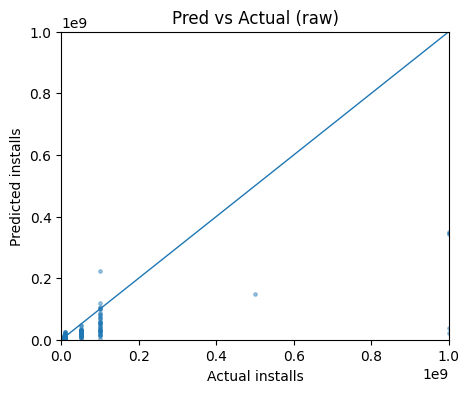

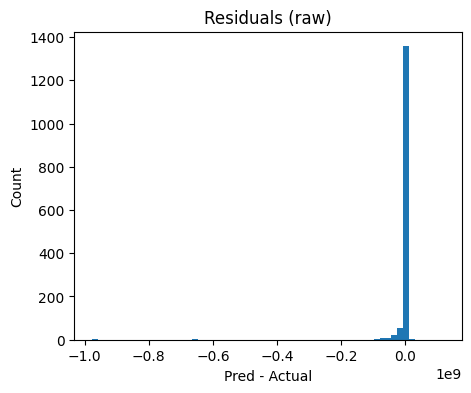

In [19]:
# Full-set evaluation for the ONNX MLP (uses X_test, y_test and artifacts in /kaggle/working/artifacts)
import numpy as np, onnxruntime as ort, pickle, json, matplotlib.pyplot as plt

# load artifacts
ART = "/kaggle/working/artifacts"
sess   = ort.InferenceSession(f"{ART}/gplay_loginstalls_best.onnx")
scaler = pickle.load(open(f"{ART}/numeric_scaler.pkl","rb"))
meta   = json.load(open(f"{ART}/deploy_meta.json"))
meds   = json.load(open(f"{ART}/impute_medians.json"))["train_numeric_medians"]
num_idx = np.array(meta["num_col_idx"], dtype=int)

# preprocess numeric slice (impute + quantile scale)
Xe = X_test.copy().astype(np.float32)
cols = num_idx
colvals = Xe[:, cols]
bad = ~np.isfinite(colvals)
if bad.any():
    colvals[bad] = np.array(meds, dtype=np.float32)[bad]
Xe[:, cols] = scaler.transform(colvals)

# inference
pred_log = sess.run(["output"], {"input": Xe})[0].ravel()
true_log = y_test
pred_raw = np.expm1(pred_log)
true_raw = np.expm1(true_log)

# metrics
def r2(y, p): 
    ybar = y.mean(); return 1.0 - np.sum((y-p)**2)/np.sum((y-ybar)**2)
r2_log  = r2(true_log, pred_log)
r2_raw  = r2(true_raw, pred_raw)
mae     = np.mean(np.abs(true_raw - pred_raw))
mape    = np.mean(np.abs(true_raw - pred_raw) / np.clip(true_raw, 1, None)) * 100

print(f"R² (log):  {r2_log:.4f}")
print(f"R² (raw):  {r2_raw:.4f}")
print(f"MAE:       {mae:,.0f}")
print(f"MAPE:      {mape:.2f}%")

# quick plots
plt.figure(figsize=(5,4))
plt.scatter(true_raw, pred_raw, s=6, alpha=0.4)
lims = [min(true_raw.min(), pred_raw.min()), max(true_raw.max(), pred_raw.max())]
plt.plot(lims, lims, lw=1); plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Actual installs"); plt.ylabel("Predicted installs")
plt.title("Pred vs Actual (raw)"); plt.show()

plt.figure(figsize=(5,4))
resid = pred_raw - true_raw
plt.hist(resid, bins=60)
plt.title("Residuals (raw)"); plt.xlabel("Pred - Actual"); plt.ylabel("Count"); plt.show()


In [20]:
import numpy as np, pandas as pd

# derive bucket edges from your original column (or hardcode a common set)
bins = (pd.Series(df_proc["Installs"].astype(str)
                  .str.replace("+","",regex=False)
                  .str.replace(",","",regex=False))
        .astype("int64")
        .unique())
bins = np.sort(bins)  # e.g., [0, 10, 50, 100, 500, 1000, ...]
# snap predictions and truths to the nearest bucket
def to_bucket(x):
    i = np.abs(bins - x).argmin()
    return bins[i]

pred_bucket = np.vectorize(to_bucket)(pred_raw)
true_bucket = np.vectorize(to_bucket)(true_raw)

acc = (pred_bucket == true_bucket).mean()
top1_off_by_one = np.mean(
    [abs(np.where(bins==pb)[0][0] - np.where(bins==tb)[0][0]) <= 1
     for pb, tb in zip(pred_bucket, true_bucket)]
)

print(f"Bucket accuracy (exact bin): {acc:.3f}")
print(f"Bucket accuracy (±1 bin):    {top1_off_by_one:.3f}")

# Confusion matrix (small view)
cm = pd.crosstab(pd.Series(true_bucket, name="True"), pd.Series(pred_bucket, name="Pred"))
cm.head(10)


Bucket accuracy (exact bin): 0.438
Bucket accuracy (±1 bin):    0.881


Pred,5,10,50,100,500,1000,5000,10000,50000,100000,500000,1000000,5000000,10000000,50000000,100000000,500000000
True,,,,,,,,,,,,,,,,,
0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,6,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,27,15,11,2,0,0,0,0,0,0,0,0,0,0,0,0
50,0,10,7,10,0,0,0,0,0,0,0,0,0,0,0,0,0
100,0,21,23,50,17,5,0,0,0,0,0,0,0,0,0,0,0
500,0,2,1,21,17,10,0,0,0,0,0,0,0,0,0,0,0
1000,0,0,1,18,30,63,26,5,0,0,0,0,0,0,0,0,0
5000,0,1,0,2,2,24,39,12,1,0,0,0,0,0,0,0,0


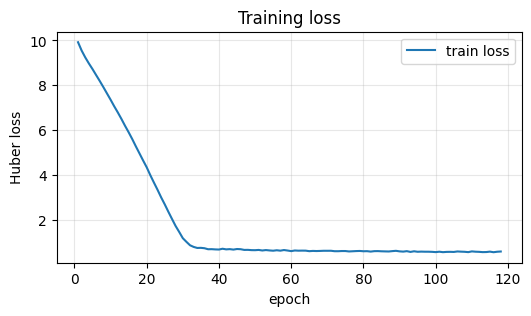

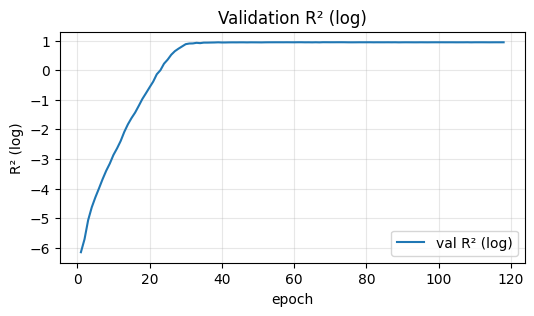

Best validation R²(log): 0.9438 at epoch 68


In [21]:
# === Re-train best MLP briefly to CAPTURE HISTORY and plot learning curves ===
# Safe: uses your existing train/val split; does NOT overwrite your saved artifacts.

import numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED); np.random.seed(SEED)

# --- small helpers (same style as before) ---
def mk_loader(X, y, shuffle=False, bs=512):
    return DataLoader(TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
                      batch_size=bs, shuffle=shuffle)

class MLP_BN(nn.Module):
    def __init__(self, d, hidden=(512,256,128), drop=0.2):
        super().__init__()
        layers=[]; last=d
        for h in hidden:
            layers += [nn.Linear(last,h), nn.BatchNorm1d(h), nn.ReLU()]
            if drop>0: layers += [nn.Dropout(drop)]
            last=h
        layers += [nn.Linear(last,1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x).squeeze(1)

@torch.no_grad()
def r2_log(model, loader):
    from sklearn.metrics import r2_score
    model.eval(); P=[]; T=[]
    for xb,yb in loader:
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)
        P.append(model(xb).float().cpu().numpy()); T.append(yb.float().cpu().numpy())
    return r2_score(np.concatenate(T), np.concatenate(P))

def train_with_history(model, trL, vaL, lr=3e-4, wd=1e-4, epochs=450, patience=50, clip=1.0):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    loss = nn.HuberLoss(delta=1.0)
    sch  = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=lr*0.1)
    best=-1e18; best_state=None; noimp=0
    hist=[]

    for ep in range(1, epochs+1):
        model.train(); tr_loss = 0.0; n = 0
        for xb,yb in trL:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); l = loss(model(xb), yb); l.backward()
            if clip: nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step(); tr_loss += float(l.detach().cpu()) * len(xb); n += len(xb)
        sch.step()
        tr_loss /= max(n,1)
        vr2 = r2_log(model, vaL)
        hist.append({"epoch": ep, "train_loss": tr_loss, "val_r2_log": float(vr2)})

        if vr2 > best + 1e-6:
            best, best_state, noimp = vr2, {k:v.cpu() for k,v in model.state_dict().items()}, 0
        else:
            noimp += 1
        if noimp >= patience: break

    # restore best weights (in-memory only)
    if best_state is not None:
        model.load_state_dict({k:v.to(DEVICE) for k,v in best_state.items()})
    return model, best, hist

# --- build scaled train/val the same way as before (Quantile on numeric-only) ---

# We try to use your existing split names; adjust if your variable names differ.
# Expected available: X_train, X_val, y_train, y_val, num_col_idx
assert 'X_train' in globals() and 'X_val' in globals() and 'y_train' in globals() and 'y_val' in globals(), \
    "Need X_train/X_val/y_train/y_val in memory. Re-run your split cell first."
assert 'num_col_idx' in globals(), "Need num_col_idx (numeric column indices)."

Xtr, Xva = X_train.copy().astype(np.float32), X_val.copy().astype(np.float32)
ytr, yva = y_train.astype(np.float32), y_val.astype(np.float32)

sc_hist = QuantileTransformer(output_distribution="normal", random_state=SEED,
                              n_quantiles=min(1000, Xtr.shape[0]))
Xtr[:, num_col_idx] = sc_hist.fit_transform(Xtr[:, num_col_idx])
Xva[:, num_col_idx] = sc_hist.transform(Xva[:, num_col_idx])

trL = mk_loader(Xtr, ytr, shuffle=True)
vaL = mk_loader(Xva, yva, shuffle=False)

# --- re-train to capture history with your best config ---
mlp_hist = MLP_BN(Xtr.shape[1], hidden=(512,256,128), drop=0.2).to(DEVICE)
mlp_hist, best_r2, history = train_with_history(
    mlp_hist, trL, vaL,
    lr=3e-4, wd=1e-4, epochs=450, patience=50, clip=1.0
)

# --- plot learning curves ---
import pandas as pd
h = pd.DataFrame(history)
plt.figure(figsize=(6,3))
plt.plot(h["epoch"], h["train_loss"], label="train loss")
plt.xlabel("epoch"); plt.ylabel("Huber loss"); plt.title("Training loss"); plt.legend(); plt.grid(alpha=.3); plt.show()

plt.figure(figsize=(6,3))
plt.plot(h["epoch"], h["val_r2_log"], label="val R² (log)")
plt.xlabel("epoch"); plt.ylabel("R² (log)"); plt.title("Validation R² (log)"); plt.legend(); plt.grid(alpha=.3); plt.show()

print(f"Best validation R²(log): {best_r2:.4f} at epoch {int(h.iloc[h['val_r2_log'].idxmax()]['epoch'])}")


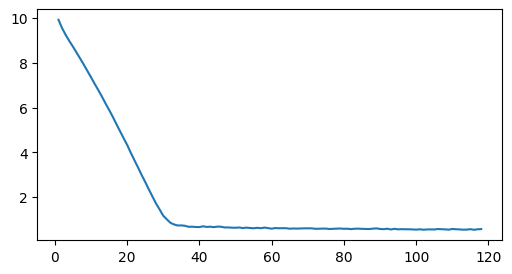

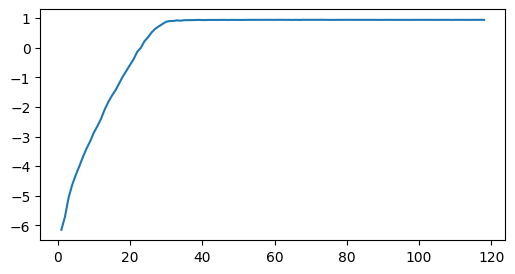

In [22]:
fig1 = plt.figure(figsize=(6,3))
plt.plot(h["epoch"], h["train_loss"], label="train loss")
...
fig1.savefig("/kaggle/working/training_loss.png", dpi=200, bbox_inches="tight")

fig2 = plt.figure(figsize=(6,3))
plt.plot(h["epoch"], h["val_r2_log"], label="val R² (log)")
...
fig2.savefig("/kaggle/working/val_r2_log.png", dpi=200, bbox_inches="tight")


In [23]:
X.shape, y.shape, len(num_col_idx), df_proc is not None, SEED, DEVICE


((9744, 74), (9744,), 6, True, 42, device(type='cuda'))

In [24]:
# === Upgrade: add TF-IDF(App name) -> SVD(50), retrain with Quantile scaler, and export if better ===
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score
import numpy as np, pandas as pd, json, os, pickle, torch

# 0) Baseline numbers you got earlier (optional; set to None if unknown)
prev_r2_log  = None   # e.g., 0.9427
prev_r2_orig = None   # e.g., 0.3837

# 1) Build 50-dim text features from App name
text = (df_proc["App"] if "App" in df_proc.columns else df_raw["App"]).astype(str).fillna("")
tfidf = TfidfVectorizer(lowercase=True, ngram_range=(1,2), max_features=2000, min_df=3)
X_tfidf = tfidf.fit_transform(text)                # [n, 2000] sparse
svd = TruncatedSVD(n_components=50, random_state=SEED)
Z = svd.fit_transform(X_tfidf).astype("float32")   # [n, 50]

# 2) Append to your encoded matrix X (built earlier)
X_aug = np.hstack([X.values.astype("float32"), Z])

# Treat the 50 SVD columns as extra numeric
num_idx_aug = num_col_idx + list(range(X.shape[1], X_aug.shape[1]))

# 3) Split
X_tr, X_tmp, y_tr, y_tmp = train_test_split(X_aug, y, test_size=0.30, random_state=SEED)
X_va, X_te, y_va, y_te   = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=SEED)

# 4) Impute numeric NaNs using TRAIN medians (same policy as before)
def impute_numeric_with_train_median(X_train, X_val, X_test, num_idx):
    Xt, Xv, Xe = X_train.copy(), X_val.copy(), X_test.copy()
    meds = np.nanmedian(Xt[:, num_idx], axis=0)
    def fill(arr):
        for j, k in enumerate(num_idx):
            col = arr[:, k]
            bad = ~np.isfinite(col)
            if bad.any():
                col[bad] = meds[j]
                arr[:, k] = col
        return arr
    Xt = fill(Xt); Xv = fill(Xv); Xe = fill(Xe)
    return Xt.astype(np.float32), Xv.astype(np.float32), Xe.astype(np.float32), meds

X_tr, X_va, X_te, train_meds = impute_numeric_with_train_median(X_tr, X_va, X_te, num_idx_aug)

# 5) Quantile scale numeric columns (works best in your results)
sc = QuantileTransformer(output_distribution="normal", random_state=SEED,
                         n_quantiles=min(1000, X_tr.shape[0]))
Xt, Xv, Xe = [arr.copy() for arr in (X_tr, X_va, X_te)]
Xt[:, num_idx_aug] = sc.fit_transform(Xt[:, num_idx_aug])
Xv[:, num_idx_aug] = sc.transform(Xv[:, num_idx_aug])
Xe[:, num_idx_aug] = sc.transform(Xe[:, num_idx_aug])
Xt = np.nan_to_num(Xt, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
Xv = np.nan_to_num(Xv, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
Xe = np.nan_to_num(Xe, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

# 6) Train MLP (reuse your helpers/classes)
trL = mk_loader(Xt, y_tr, True)
vaL = mk_loader(Xv, y_va, False)
teL = mk_loader(Xe, y_te, False)

mlp = MLP_BN(Xt.shape[1], hidden=(512,256,128), drop=0.2).to(DEVICE)
mlp, _ = train(mlp, trL, vaL, lr=3e-4, wd=1e-4, epochs=400, patience=40)

@torch.no_grad()
def r2_log(model, loader):
    model.eval(); P=[]; T=[]
    for xb,yb in loader:
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)
        P.append(model(xb).float().cpu().numpy()); T.append(yb.float().cpu().numpy())
    return r2_score(np.concatenate(T), np.concatenate(P))

@torch.no_grad()
def r2_original_scale(model, loader):
    model.eval(); P=[]; T=[]
    for xb,yb in loader:
        xb = xb.to(DEVICE)
        p = model(xb).float().cpu().numpy()
        P.append(np.expm1(p)); T.append(np.expm1(yb.float().cpu().numpy()))
    return r2_score(np.concatenate(T), np.concatenate(P))

r2_log_new  = r2_log(mlp, teL)
r2_orig_new = r2_original_scale(mlp, teL)
print("With TF-IDF(SVD50) → MLP  | R²(log):", round(float(r2_log_new),4),
      "| R²(orig):", round(float(r2_orig_new),4))

# 7) If better (or anyway), export to a new folder so you can compare
ART2 = "/kaggle/working/artifacts_plus_text"; os.makedirs(ART2, exist_ok=True)

# Save scaler, impute medians, and new feature order
# Build the combined feature order: original feature columns + SVD names
svd_cols = [f"svd_name_{i:02d}" for i in range(Z.shape[1])]
feature_cols_aug = X.columns.tolist() + svd_cols

deploy = {
    "feature_cols_order": feature_cols_aug,
    "num_col_idx": num_idx_aug,
    "num_col_count": len(num_idx_aug),
    "target": "log_installs",
    "scaler": "quantile",
    "note": "Before ONNX: encode to feature_cols_order, impute numeric with medians, then apply quantile scaler."
}
with open(os.path.join(ART2, "deploy_meta.json"), "w") as f:
    json.dump(deploy, f, indent=2)

impute_meta = {
    "numeric_column_indices": num_idx_aug,
    "train_numeric_medians": [float(m) for m in train_meds]
}
with open(os.path.join(ART2, "impute_medians.json"), "w") as f:
    json.dump(impute_meta, f, indent=2)

# Save scaler
pickle.dump(sc, open(os.path.join(ART2, "numeric_scaler.pkl"), "wb"))

# Save ONNX model (expects already-encoded+imputed+scaled input with augmented order)
dummy = torch.from_numpy(Xe[:1]).to(DEVICE)
onnx_path = os.path.join(ART2, "gplay_loginstalls_best_plus_text.onnx")
torch.onnx.export(mlp, dummy, onnx_path,
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={"input":{0:"batch"},"output":{0:"batch"}},
                  opset_version=17)

# Log deltas vs previous (if provided)
if prev_r2_log is not None and prev_r2_orig is not None:
    print("Δ R²(log):", round(float(r2_log_new - prev_r2_log),4),
          "| Δ R²(orig):", round(float(r2_orig_new - prev_r2_orig),4))

print("Saved new artifacts in", ART2, "→", os.listdir(ART2))


With TF-IDF(SVD50) → MLP  | R²(log): 0.9382 | R²(orig): 0.5444
Saved new artifacts in /kaggle/working/artifacts_plus_text → ['deploy_meta.json', 'numeric_scaler.pkl', 'impute_medians.json', 'gplay_loginstalls_best_plus_text.onnx']


In [25]:
# ===== Web export (QuantileTransformer version) =====
import os, json, numpy as np, torch

# Expect these from your notebook:
# - Quantile-trained ONNX: /kaggle/working/artifacts/gplay_loginstalls_best.onnx
# - Quantile scaler object: artifacts/numeric_scaler.pkl  OR variable `scaler`
# - meta: artifacts/deploy_meta.json (has feature order + num_col_idx)
ART = "/kaggle/working/artifacts"
onnx_src = os.path.join(ART, "gplay_loginstalls_best.onnx")
meta = json.load(open(os.path.join(ART, "deploy_meta.json")))
feature_cols_order = meta["feature_cols_order"]
num_col_idx = meta["num_col_idx"]

# Load the quantile scaler (it was saved in your earlier pipeline)
import pickle
qt = pickle.load(open(os.path.join(ART, "numeric_scaler.pkl"), "rb"))

# Safety checks
assert hasattr(qt, "quantiles_"), "This export expects a QuantileTransformer as numeric scaler."
Q = qt.quantiles_  # shape: (n_quantiles, n_features_numeric)
nq, nf = Q.shape

# Also ship your train numeric medians for imputation
impute = json.load(open(os.path.join(ART, "impute_medians.json")))
meds = impute["train_numeric_medians"]

# Fixed bins for nearest bucket display
bins = [0,5,10,50,100,500,1_000,5_000,10_000,50_000,100_000,
        500_000,1_000_000,5_000_000,10_000_000,50_000_000,
        100_000_000,500_000_000,1_000_000_000]

WEB = "/kaggle/working/web_q"; os.makedirs(WEB, exist_ok=True)

# 1) Copy ONNX (quantile-trained model)
import shutil
onnx_dst = os.path.join(WEB, "gplay_loginstalls_quantile.onnx")
shutil.copyfile(onnx_src, onnx_dst)

# 2) Write meta JSON with quantiles and indices
meta_q = {
    "feature_cols_order": feature_cols_order,
    "num_col_idx": [int(i) for i in num_col_idx],
    "quantiles": Q.tolist(),              # (n_quantiles x n_numeric_features)
    "n_quantiles": int(nq),
    "output_distribution": "normal",      # how to finish the mapping
    "train_numeric_medians": [float(m) for m in meds],
    "bins": bins,
    "target": "log_installs",
    "note": "Preprocess in browser: 1) set one-hots by name; 2) impute numeric with train medians; 3) apply quantile→normal; 4) ONNX; 5) expm1."
}
json.dump(meta_q, open(os.path.join(WEB, "meta_quantile.json"), "w"), indent=2)

# 3) Minimal HTML/JS (Quantile version)
index_html = """<!doctype html>
<html>
<head>
  <meta charset="utf-8" />
  <meta name="viewport" content="width=device-width,initial-scale=1" />
  <title>Google Play Installs — Quantile Demo</title>
  <style>
    body{font-family:system-ui,Arial;margin:24px;max-width:900px}
    .card{border:1px solid #ddd;border-radius:12px;padding:16px;margin-bottom:16px}
    label{display:block;margin:6px 0 2px}
    input,select,button{padding:8px;font-size:14px}
    .row{display:grid;grid-template-columns:repeat(auto-fit,minmax(220px,1fr));gap:12px}
    .muted{color:#666}
    .out{white-space:pre-wrap;background:#f8f8f8;padding:12px;border-radius:8px;border:1px solid #eee}
  </style>
</head>
<body>
  <h2>Google Play Installs — Quantile (ONNX, client-side)</h2>
  <div class="card">
    <p class="muted">QuantileTransformer + probit is applied in the browser to match training.</p>
    <div class="row">
      <div><label>Category</label><input id="category" placeholder="e.g., art_and_design" /></div>
      <div><label>Content Rating</label><input id="contentRating" placeholder="e.g., everyone" /></div>
      <div><label>Genre (primary)</label><input id="genre" placeholder="e.g., art & design" /></div>
      <div><label>Reviews (count)</label><input id="reviews" type="number" value="5000" /></div>
      <div><label>Rating (0–5)</label><input id="rating" type="number" step="0.1" value="4.2" /></div>
      <div><label>Size (MB)</label><input id="size" type="number" step="0.1" value="12" /></div>
      <div><label>Price (USD)</label><input id="price" type="number" step="0.01" value="0" /></div>
      <div><label>Paid?</label>
        <select id="type"><option value="free">Free</option><option value="paid">Paid</option></select>
      </div>
    </div>
    <div style="margin-top:12px">
      <button id="predict">Predict installs</button>
    </div>
  </div>

  <div class="card">
    <div class="out" id="out">Ready.</div>
  </div>

  <script src="https://cdn.jsdelivr.net/npm/onnxruntime-web@1.19.2/dist/ort.min.js"></script>
  <script src="./app_quantile.js"></script>
</body>
</html>
"""
open(os.path.join(WEB, "index.html"), "w").write(index_html)

app_js = r"""// app_quantile.js — apply QuantileTransformer (uniform->normal) in browser
let sess, meta;

function lower(s){ return (s||"").toString().trim().toLowerCase(); }
function clamp01(p){ return Math.min(1-1e-12, Math.max(1e-12, p)); }

// Φ^{-1}(p): inverse normal CDF (probit) — rational approximation (Beasley-Springer/Moro style)
function probit(p){
  // Abramowitz & Stegun style approximation
  const a1=-39.6968302866538, a2=220.946098424521, a3=-275.928510446969,
        a4=138.357751867269, a5=-30.6647980661472, a6=2.50662827745924;
  const b1=-54.4760987982241, b2=161.585836858041, b3=-155.698979859887,
        b4=66.8013118877197, b5=-13.2806815528857;
  const c1=-7.78489400243029e-03, c2=-0.322396458041136, c3=-2.40075827716184,
        c4=-2.54973253934373, c5=4.37466414146497, c6=2.93816398269878;
  const d1=7.78469570904146e-03, d2=0.32246712907004, d3=2.445134137143,
        d4=3.75440866190742;
  const plow=0.02425, phigh=1-plow;
  let q, r;
  if (p < plow){
    q = Math.sqrt(-2*Math.log(p));
    return (((((c1*q+c2)*q+c3)*q+c4)*q+c5)*q+c6) /
           ((((d1*q+d2)*q+d3)*q+d4)*q+1);
  }
  if (phigh < p){
    q = Math.sqrt(-2*Math.log(1-p));
    return -(((((c1*q+c2)*q+c3)*q+c4)*q+c5)*q+c6) /
             ((((d1*q+d2)*q+d3)*q+d4)*q+1);
  }
  q = p-0.5; r = q*q;
  return (((((a1*r+a2)*r+a3)*r+a4)*r+a5)*r+a6)*q /
         (((((b1*r+b2)*r+b3)*r+b4)*r+b5)*r+1);
}

// Given a value v and the quantiles array q (length nQ), compute uniform CDF via piecewise linear interpolation
function cdfFromQuantiles(v, q){
  const n = q.length;
  if (v <= q[0]) return 0.0;
  if (v >= q[n-1]) return 1.0;
  // binary search for interval
  let lo=0, hi=n-1;
  while (hi-lo>1){
    const mid = (lo+hi)>>1;
    if (v < q[mid]) hi=mid; else lo=mid;
  }
  const t = (v - q[lo]) / Math.max(1e-12, (q[hi]-q[lo]));
  const p_lo = lo/(n-1), p_hi = hi/(n-1);
  return p_lo + (p_hi - p_lo) * t;
}

async function loadAll(){
  meta = await (await fetch('./meta_quantile.json')).json();
  sess = await ort.InferenceSession.create('./gplay_loginstalls_quantile.onnx');
  log('Loaded model + quantiles.');
}
function log(msg){
  const el = document.getElementById('out');
  el.textContent = (el.textContent ? el.textContent + '\n' : '') + msg;
}

function buildVector(){
  const feats = meta.feature_cols_order;
  const x = new Float32Array(feats.length); // zeros

  const cat = lower(document.getElementById('category').value);
  const cr  = lower(document.getElementById('contentRating').value);
  const gp  = lower(document.getElementById('genre').value);
  const reviews = parseFloat(document.getElementById('reviews').value);
  const rating  = parseFloat(document.getElementById('rating').value);
  const sizeMB  = parseFloat(document.getElementById('size').value);
  const price   = parseFloat(document.getElementById('price').value);
  const typeSel = lower(document.getElementById('type').value);

  const put = (name, val)=>{
    const i = feats.indexOf(name);
    if(i>=0) x[i] = Number.isFinite(val)? val : NaN;
  };
  put('Price_num', price);
  put('Size_MB',   sizeMB);
  put('Reviews_num', reviews);
  put('Rating_num',  rating);
  put('Type_is_paid', typeSel==='paid'? 1 : 0);
  put('days_since_update', NaN); // imputed below

  const hot = (prefix, level)=>{
    const col = `${prefix}${level}`;
    let idx = feats.indexOf(col);
    if(idx>=0){ x[idx] = 1; return; }
    const other = `${prefix}other`;
    idx = feats.indexOf(other);
    if(idx>=0) x[idx] = 1;
  };
  hot('Category_cat_',      cat);
  hot('ContentRating_cat_', cr);
  hot('Genre_primary_',     gp);

  // --- Numeric impute ---
  const numIdx = meta.num_col_idx;
  const meds = meta.train_numeric_medians;
  for(let k=0;k<numIdx.length;k++){
    const j = numIdx[k];
    if(!Number.isFinite(x[j])) x[j] = meds[k];
  }

  // --- Quantile -> (uniform) -> normal (probit) ---
  const Q = meta.quantiles;           // [nQ][nNum]
  const nQ = meta.n_quantiles|0;
  for(let k=0;k<numIdx.length;k++){
    const j = numIdx[k];
    // collect k-th feature’s quantiles
    const q = new Array(nQ);
    for(let i=0;i<nQ;i++){ q[i] = Q[i][k]; }
    // uniform CDF in [0,1]
    const pu = cdfFromQuantiles(x[j], q);
    // to normal
    const p = clamp01(pu);
    x[j] = probit(p);
  }

  // Safety: replace any remaining non-finite
  for(let i=0;i<x.length;i++){
    if(!Number.isFinite(x[i])) x[i] = 0.0;
  }
  return x;
}

function toBucket(v){
  const bins = meta.bins;
  let best = bins[0], bestd = Math.abs(v - bins[0]);
  for(const b of bins){
    const d = Math.abs(v-b);
    if(d<bestd){ best=b; bestd=d; }
  }
  return best;
}

async function predict(){
  try{
    const x = buildVector();
    const feeds = { input: new ort.Tensor('float32', x, [1, x.length]) };
    const out = await sess.run(feeds);
    const ylog = out.output.data[0];
    const installs = Math.expm1(ylog);
    const bucket = toBucket(installs);
    document.getElementById('out').textContent =
      `Predicted installs: ${Math.round(installs).toLocaleString()}  (nearest bucket: ${bucket.toLocaleString()}+)`;
  }catch(err){
    document.getElementById('out').textContent = 'Error: ' + err;
    console.error(err);
  }
}

document.getElementById('predict').addEventListener('click', predict);
loadAll();
"""
open(os.path.join(WEB, "app_quantile.js"), "w").write(app_js)

print("Wrote:", os.listdir(WEB))


Wrote: ['app_quantile.js', 'meta_quantile.json', 'gplay_loginstalls_quantile.onnx', 'index.html']


In [26]:
!cd /kaggle/working && zip -r web_quantile_demo.zip web_q


  adding: web_q/ (stored 0%)
  adding: web_q/app_quantile.js (deflated 56%)
  adding: web_q/meta_quantile.json (deflated 90%)
  adding: web_q/gplay_loginstalls_quantile.onnx (deflated 8%)
  adding: web_q/index.html (deflated 56%)


In [27]:
import json, numpy as np, os
ix = 0  # pick any row from X_test you used in the ONNX test cell
gold = {
  "raw": {
    "Category": str(df_proc.iloc[ix]["Category"]),
    "Content Rating": str(df_proc.iloc[ix]["Content Rating"]),
    "Genres": str(df_proc.iloc[ix]["Genres"]),
    "Reviews": float(df_proc.iloc[ix]["Reviews"]),
    "Rating": float(df_proc.iloc[ix]["Rating"]),
    "Size": str(df_proc.iloc[ix]["Size"]),
    "Price": str(df_proc.iloc[ix]["Price"]),
    "Type": str(df_proc.iloc[ix]["Type"]),
    "Last Updated": str(df_proc.iloc[ix]["Last Updated"]),
  },
  "y_true": float(np.expm1(y_test[ix])),      # true installs
  "y_pred": float(np.expm1(pred_log[ix]))     # MLP ONNX pred you computed
}
with open("/kaggle/working/web_q/smoke.json","w") as f: json.dump(gold,f,indent=2)


In [28]:
from sklearn.model_selection import train_test_split
import numpy as np

idx_all = X.index.to_numpy()                # keep row ids
X_np = X.values.astype(np.float32)

X_train, X_tmp, y_train, y_tmp, idx_tr, idx_tmp = train_test_split(
    X_np, y, idx_all, test_size=0.30, random_state=SEED
)
X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
    X_tmp, y_tmp, idx_tmp, test_size=0.50, random_state=SEED
)


In [29]:
import xgboost as xgb
from sklearn.metrics import r2_score

feat_names = [f"f{i}" for i in range(X_train.shape[1])]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feat_names)
dval   = xgb.DMatrix(X_val,   label=y_val,   feature_names=feat_names)
dtest  = xgb.DMatrix(X_test,  label=y_test,  feature_names=feat_names)

params = {
    "objective":"reg:squarederror", "eval_metric":"rmse",
    "eta":0.05, "max_depth":8, "subsample":0.8, "colsample_bytree":0.8,
    "min_child_weight":4, "lambda":1.0, "seed":SEED,
}
bst = xgb.train(params, dtrain, num_boost_round=800,
                evals=[(dtrain,"train"),(dval,"val")],
                early_stopping_rounds=50, verbose_eval=False)

pred_log = bst.predict(dtest)
pred_raw = np.expm1(pred_log)


In [30]:
import json
import pandas as pd
import os, math

# Where to save for your website repo (adjust the folder name you use):
WEB = "/kaggle/working/web_q"
os.makedirs(WEB, exist_ok=True)

def size_to_str(x):
    # convert float MB → "12M"
    try:
        v = float(x)
        if math.isnan(v): return ""
        return f"{v:.0f}M"
    except:
        return str(x) if x is not None else ""

def row_to_raw(row: pd.Series) -> dict:
    """Map df_proc row → the raw fields your page expects."""
    return {
        "Category":       row.get("Category", ""),
        "Content Rating": row.get("Content Rating", ""),
        "Genres":         row.get("Genres", ""),
        "Reviews":        row.get("Reviews", None),
        "Rating":         row.get("Rating", None),
        "Size":           size_to_str(row.get("Size_MB", row.get("Size", ""))),
        "Price":          str(row.get("Price", "0")),
        "Type":           row.get("Type", "Free"),
        # "Last Updated": row.get("Last Updated", ""),   # optional (not on your page)
    }

# Build 200 cases (or more/less)
N = min(200, len(idx_test))
cases = []
for k in range(N):
    ridx = idx_test[k]
    row  = df_proc.loc[ridx]         # original-ish row
    cases.append({
        "id": int(ridx),
        "raw": row_to_raw(row),
        "y_true": float(np.expm1(y_test[k])),
        "y_pred": float(pred_raw[k])
    })

with open(os.path.join(WEB, "smoke_large.json"), "w") as f:
    json.dump(cases, f, ensure_ascii=False, indent=2)

len(cases), cases[0]


(200,
 {'id': 1962,
  'raw': {'Category': 'GAME',
   'Content Rating': 'Everyone 10+',
   'Genres': 'Action',
   'Reviews': '3073251',
   'Rating': 4.6,
   'Size': '33M',
   'Price': '0',
   'Type': 'Free'},
  'y_true': 49999988.0,
  'y_pred': 48826836.0})